# Bird Observation Data

### Import libraries and configure environment variable

In [3]:
import requests
import csv
import pandas as pd

import os
from sqlalchemy import create_engine, Table, Column, String, MetaData, Date, Integer, Boolean
from sqlalchemy.orm import sessionmaker

from dotenv import load_dotenv
load_dotenv()
api_key = os.environ.get('EBIRD_API_KEY')

### GET Requests to eBird API

In [5]:
# Fetches all recent recorded observations in PA
recent_observations_url = 'https://api.ebird.org/v2/data/obs/US-PA/recent'
recent_observations_params = {'key': os.environ.get('EBIRD_API_KEY')}
recent_observations = requests.get(recent_observations_url, params=recent_observations_params)

# Handle potential JSONDecodeError
try:
    recent_observations_data = recent_observations.json()
except requests.exceptions.JSONDecodeError:
    print("Error decoding JSON response for recent_observations:")
    print(recent_observations.text)
    exit(1)

In [6]:
# Fetches PA birding hotspots (in JSON format)
pa_hotspots_url = 'https://api.ebird.org/v2/ref/hotspot/US-PA?fmt=json'
pa_hotspots_params = {'key': os.environ.get('EBIRD_API_KEY')}
pa_hotspots = requests.get(pa_hotspots_url, params=pa_hotspots_params)

# Handle potential JSONDecodeError
try:
    pa_hotspots_data = pa_hotspots.json()
except requests.exceptions.JSONDecodeError:
    print("Error decoding JSON response for pa_hotspots:")
    print(pa_hotspots.text)
    exit(1)

In [7]:
# # Fetches details about particular hotspot
# # This won't work until I have a location ID
# hotspot_info_url = 'https://api.ebird.org/v2/ref/hotspot/info/{locId}'
# hotspot_info_params = {'key': os.environ.get('EBIRD_API_KEY')}
# hotspot_info = requests.get(hotspot_info_url, params=hotspot_info_params)

# # Handle potential JSONDecodeError
# try:
#     hotspot_info_data = hotspot_info.json()
# except requests.exceptions.JSONDecodeError:
#     print("Error decoding JSON response for hotspot_info:")
#     print(hotspot_info.text)
#     exit(1)

### Create DataFrames

In [8]:
# Create a DataFrame to hold API observation response data
pa_observations_df = pd.DataFrame(recent_observations_data)

# Create a DataFrame to hold API response data for list of PA hotspots
pa_hotspots_df = pd.DataFrame(pa_hotspots_data)

# # Create a DataFrame to hold API response for hotspot location info
# hotspot_info_df = pd.DataFrame(hotspot_info_data)

### Clean Returned Data

In [9]:
# Drop unneeded columns from observation data

# Specify the columns to be dropped
columns_to_drop = ['obsValid', 'obsReviewed', 'subId', 'exoticCategory']

# Drop the specified columns from the DataFrame
pa_observations_df = pa_observations_df.drop(columns=columns_to_drop)

In [10]:
# Drop unneeded columns from the hotspot data

# Specify the columns to be dropped
columns_to_drop = ['countryCode', 'subnational1Code']

# Drop the specified columns from the DataFrame
pa_hotspots_df = pa_hotspots_df.drop(columns=columns_to_drop)

In [11]:
# Rename columns for clarity in observation data
pa_observations_df = pa_observations_df.rename(columns={'speciesCode': 'Species_Code', 'comName': 'Common_Name', 'sciName': 'Scientific_Name', 
                                                        'locId': 'Location_ID', 'locName': 'Location_Name', 'obsDt' : 'Observation_Date', 
                                                        'howMany': 'Quantity_Observed', 'lat': 'Latitude', 'lng': 'Longitude', 
                                                        'locationPrivate': 'Location_Private'})

In [ ]:
print(pa_observations_df.head())

In [13]:
# Rename columns for clarity in hotspot data
pa_hotspots_df = pa_hotspots_df.rename(columns={'locId': 'Location_ID', 'locName': 'Location_Name', 'subnational2Code': 'Sub-National_Code',
                                                 'lat': 'Latitude', 'lng': 'Longitude', 'latestObsDt': 'Date_of_Most_Recent_Observation', 
                                                 'numSpeciesAllTime': 'Total_Species_Recorded_at_Location'})

### Write cleaned data to CSV files

In [15]:
# Write recent observations response to a CSV file
pa_observations_df.to_csv('recent_observations.csv', index=True)

# Write PA hotspot response to a CSV file
pa_hotspots_df.to_csv('pa_hotspots_data.csv', index=True)

### Write observation data from DataFrame to SQLite database

In [ ]:
import sqlite3

column_names = {} # set value

connection = sqlite3.connect("bird-data.db")
cursor = connection.cursor()

cursor.execute("CREATE TABLE observations (Species_Code, " + ",".join(column_names)+ ")")
for i in range(len(pa_observations_df)):
    cursor.execute("INSERT INTO observations VALUES (?,?,?,?,?,?,?)", pa_observations_df.iloc[i]) # values should be the appropriate number of query parameters (?) for the number of columns

connection.commit()

connection.close()

### Write observation data from CSV file to PostgreSQL database

In [ ]:
from sqlalchemy import Integer

# PostgreSQL database connection details from .env file
host = os.getenv('PG_HOST')
database = os.getenv('PG_DATABASE')
user = os.getenv('PG_USER')
password = os.getenv('PG_PASSWORD')

# Create SQLAlchemy engine
engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}', pool_pre_ping=True)

# Create a session factory
Session = sessionmaker(bind=engine)
session = Session()

# Type conversion of Location_ID column to remove preceding L, if necessary, to store the number as an integer.
pa_observations_df['Location_ID'] = pa_observations_df['Location_ID'].astype(str).apply(lambda x: int(x[1:]) if x.startswith('L') else int(x))

# Create SQLAlchemy table object
metadata = MetaData()
table = Table(
    'Recent_Observations',
    metadata,
    Column('Index', Integer, primary_key=True, autoincrement=True),
    Column('Species_Code', String),
    Column('Common_Name', String),
    Column('Scientific_Name', String),
    Column('Location_ID', Integer),
    Column('Location_Name', String),
    Column('Observation_Date', String),
    Column('Quantity_Observed', Integer),
    Column('Latitude', String),
    Column('Longitude', String),
    Column('Location_Private', Boolean)
)

metadata.create_all(engine)

# Insert the DataFrame into the database table
try:
    with engine.begin() as connection:
        for index, row in pa_observations_df.iterrows():
            print("Inserting row: ", row) # for debugging
            insert_stmt = table.insert().values(
                Species_Code=row['Species_Code'],
                Common_Name=row['Common_Name'],
                Scientific_Name=row['Scientific_Name'],
                Location_ID=row['Location_ID'],
                Location_Name=row['Location_Name'],
                Observation_Date=row['Observation_Date'],
                Quantity_Observed=int(row['Quantity_Observed']),
                Latitude=float(row['Latitude']),
                Longitude=float(row['Longitude']),
                Location_Private=bool(row['Location_Private'])
            )
            connection.execute(insert_stmt)

    print("Data insertion successful!")
except Exception as e:
    print("An error occurred during data insertion:", str(e))

session.commit()

In [ ]:
pa_observations_df[(pa_observations_df.Common_Name == 'Pileated Woodpecker')]

In [18]:
pa_observations_df.dtypes

Species_Code          object
Common_Name           object
Scientific_Name       object
Location_ID            int64
Location_Name         object
Observation_Date      object
Quantity_Observed    float64
Latitude             float64
Longitude            float64
Location_Private        bool
dtype: object

In [ ]:
pa_hotspots_df.head()

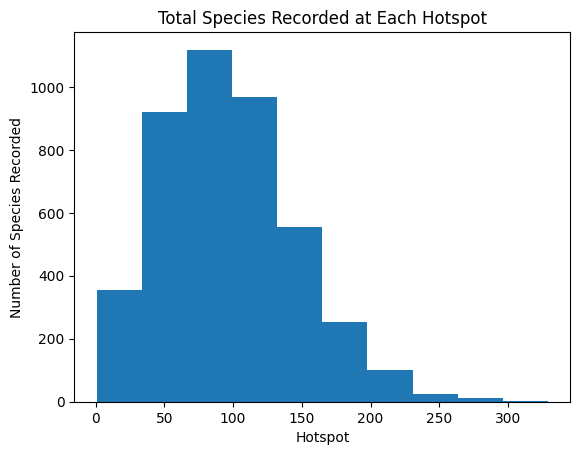

In [24]:
from matplotlib import pyplot as plt
import numpy as np

total_species_at_hotspots = pa_hotspots_df['Total_Species_Recorded_at_Location'].values

plt.hist(total_species_at_hotspots)
plt.title('Total Species Recorded at Each Hotspot')
plt.xlabel('Hotspot')
plt.ylabel('Number of Species Recorded')
plt.show()

# This histogram makes zero sense analytically, but hey, at least I have a histogram now!
